### Installing requirements

In [ ]:
#!pip3 install --user matplotlib torch numpy torchvision tqdm

In [1]:
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import tqdm
try:
    from tqdm import tqdm as iter_progress
except:
    iter_progress=lambda x:x
iter_progress=lambda x:x
from contextlib import ExitStack

### Lets work with Fashion MNIST. 

It is better than MNIST yet totally compatible from all points of view.
If you asre short on memory, reduce batch_size in the dataloaders.

Text(0.5, 1.0, 'Fashion MNIST samples')

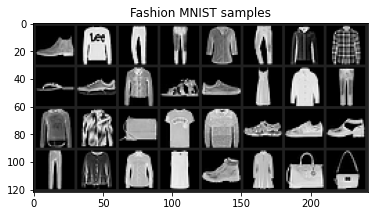

In [2]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])

transform_test = transform_train

trainset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=5)

testset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=5)

images, labels = next(iter(testloader))
img=torchvision.utils.make_grid(images[:32,:,:,:]).numpy()*.3+.13
plt.imshow(img.transpose(1,2,0))
plt.title("Fashion MNIST samples")

### Defining custom pooling layers

We define a layer that averages between max and avg pooling

We also define a layer that returns a weighted sum between max and avg pooling.
The weights of mixing as learned.

In [3]:
class MixedPooling(torch.nn.Module):
    def __init__(self, sz):
        super().__init__()
        self.mp = torch.nn.MaxPool2d(sz)
        self.ap = torch.nn.AvgPool2d(sz)
        
    def forward(self, X):
        coeffs=torch.softmax(self.prob_logits, dim=0)
        return .5 * self.mp(X) + .5 * self.ap(X)


class TunedMixedPooling(torch.nn.Module):
    def __init__(self, sz):
        super().__init__()
        self.prob_logits = torch.nn.Parameter(torch.ones(2))
        self.mp = torch.nn.MaxPool2d(sz)
        self.ap = torch.nn.AvgPool2d(sz)
        
    def forward(self, X):
        coeffs=torch.softmax(self.prob_logits, dim=0)
        return coeffs[0] * self.mp(X) + coeffs[1] * self.ap(X)

### Definining a VGG11

In this model we can select the pooling mechanism.

In [4]:
class VGG11(torch.nn.Module):
    def __init__(self, input_channels=1, output_classes=10, classifier_capacity=1024, pool="max"):
        super().__init__()
        conv2d=torch.nn.Conv2d
        self.relu = torch.nn.ReLU()
        if pool == "max":
            self.pool2d = torch.nn.MaxPool2d(2)
        elif pool == "avg":
            self.pool2d = torch.nn.AvgPool2d(2)
        elif pool == "mixed":
            self.pool2d = MixedPooling(2)
        elif pool == "mixed_tuned":
            self.pool2d = TunedMixedPooling(2)
        else:
            self.pool2d = MixedPooling(2)
        self.avg_pool2d = torch.nn.AdaptiveAvgPool2d((1,1))
        self.c1_1 = conv2d(input_channels, 64, 3, padding=1)
        self.c1_2 = conv2d(64, 128, 1)
        self.c2_1 = conv2d(128, 256, 3, padding=1)
        self.c2_2 = conv2d(256, 256, 1)
        self.c3_1 = conv2d(256, 512, 3, padding=1)
        self.c3_2 = conv2d(512, 512, 1)
        self.c4_1 = conv2d(512, 512, 3, padding=1)
        self.c4_2 = conv2d(512, 512, 1)
        self.fc1 = torch.nn.Linear(512,classifier_capacity)
        self.fc2 = torch.nn.Linear(classifier_capacity, classifier_capacity)
        self.fc_class =  torch.nn.Linear(classifier_capacity, output_classes)
        
        
        self.features = torch.nn.Sequential(self.c1_1,
                                            self.c1_2,
                                            self.relu,
                                            self.pool2d,
                                            self.c2_1,
                                            self.c2_2,
                                            self.relu,
                                            self.pool2d,
                                            self.c3_1,
                                            self.c3_2,
                                            self.relu,
                                            self.pool2d,
                                            self.c4_1,
                                            self.c4_2,
                                            self.relu,
                                            self.avg_pool2d)

        self.classifier = torch.nn.Sequential(self.fc1,
                                              self.relu,
                                              self.fc2,
                                              self.relu,
                                              self.fc_class)

    def forward(self, X):
        features = self.features(X)
        features=features.view([features.size(0),-1])
        return self.classifier(features)
        
        

### Defining a single epoch iteration for taraing and testing

Using torch.no_grad() saves a lot of memory if we don't train

In [5]:
def run_epoch(net,dataloader,criterion,device,optimizer=None):
    with ExitStack() as stack:
        if optimizer is not None:
            net.train(True)
        else:
            net.train(False)
            gs = stack.enter_context(torch.no_grad())

        accumulated_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(iter_progress(dataloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            if optimizer:
                optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            if optimizer:
                loss.backward()
                optimizer.step()
            accumulated_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        return correct,total,accumulated_loss

### Let's experiment:
We will compare max-pooling which is the standard for the VGG networks with TunedMixedPooling

We will need two networks and two optimisers
We run then concurently since we have the memory.
Otherwise we would run them one after the other.

Epoch: 0 Train Error: 89.94% Validation Error: 90.00% Loss: 541.1277434825897
Epoch: 1 Train Error: 89.68% Validation Error: 90.00% Loss: 541.0361413955688
Epoch: 2 Train Error: 86.08% Validation Error: 82.00% Loss: 540.1054191589355
Epoch: 3 Train Error: 69.22% Validation Error: 39.65% Loss: 428.43967521190643
Epoch: 4 Train Error: 35.48% Validation Error: 30.85% Loss: 215.8933001756668
Epoch: 5 Train Error: 26.84% Validation Error: 25.50% Loss: 166.35192182660103
Epoch: 6 Train Error: 22.81% Validation Error: 26.02% Loss: 142.6125368475914
Epoch: 7 Train Error: 20.49% Validation Error: 19.84% Loss: 129.09501966834068
Epoch: 8 Train Error: 19.13% Validation Error: 18.61% Loss: 120.45840209722519
Epoch: 9 Train Error: 18.17% Validation Error: 18.00% Loss: 115.06982350349426
Epoch: 10 Train Error: 16.84% Validation Error: 18.11% Loss: 106.82226678729057
Epoch: 11 Train Error: 16.33% Validation Error: 16.53% Loss: 102.75811195373535
Epoch: 12 Train Error: 15.42% Validation Error: 16.81% 

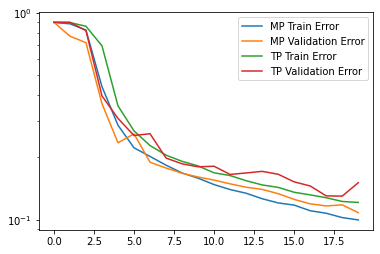

In [6]:
net_mp=VGG11(pool="max").cuda()
net_tp=VGG11(pool="mixed_tuned").cuda()

criterion = torch.nn.CrossEntropyLoss()
mp_optimizer = torch.optim.SGD(net_mp.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)
tp_optimizer = torch.optim.SGD(net_tp.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

mp_train_performance = []
mp_validation_performance = []
mp_times = [0]
tp_train_performance = []
tp_validation_performance = []
tp_times = [0]
t=time.time()

for epoch in range(20):
    train_correct,train_total,train_loss=run_epoch(net_mp, trainloader, criterion, 'cuda', mp_optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net_mp, testloader, criterion, 'cuda', None)
    test_err=1-float(test_correct)/test_total
    mp_train_performance.append(train_err)
    mp_validation_performance.append(test_err)
    mp_times.append(time.time())

    train_correct,train_total,train_loss=run_epoch(net_tp, trainloader, criterion, 'cuda', tp_optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net_tp, testloader, criterion, 'cuda', None)
    test_err=1-float(test_correct)/test_total
    
    tp_train_performance.append(train_err)
    tp_validation_performance.append(test_err)
    tp_times.append(time.time())

    print(("Epoch: {} Train Error: {:0.2f}% Validation Error: {:0.2f}% Loss: {}".format(
        epoch,100*train_err,100*test_err,train_loss)))
    plt.clf()
    plt.semilogy(range(len(mp_train_performance)),mp_train_performance)
    plt.semilogy(range(len(mp_validation_performance)), mp_validation_performance)
    plt.semilogy(range(len(tp_train_performance)), tp_train_performance)
    plt.semilogy(range(len(tp_validation_performance)), tp_validation_performance)
    plt.legend(["MP Train Error","MP Validation Error", "TP Train Error","TP Validation Error"])
    plt.draw()

### Let's resume training with a different learning rate

Epoch: 0 Train Error: 10.75% Validation Error: 12.08% Loss: 68.09186451137066
Epoch: 1 Train Error: 10.46% Validation Error: 11.84% Loss: 66.86280812323093
Epoch: 2 Train Error: 10.42% Validation Error: 11.67% Loss: 66.26766365766525
Epoch: 3 Train Error: 10.32% Validation Error: 11.61% Loss: 65.6540944725275
Epoch: 4 Train Error: 10.25% Validation Error: 11.45% Loss: 65.28626370429993
Epoch: 5 Train Error: 10.24% Validation Error: 11.43% Loss: 65.13722328841686
Epoch: 6 Train Error: 10.14% Validation Error: 11.51% Loss: 64.90310618281364
Epoch: 7 Train Error: 10.11% Validation Error: 11.58% Loss: 64.52110448479652
Epoch: 8 Train Error: 10.09% Validation Error: 11.43% Loss: 64.168966203928
Epoch: 9 Train Error: 9.99% Validation Error: 11.20% Loss: 63.713298574090004
Epoch: 10 Train Error: 9.98% Validation Error: 11.32% Loss: 63.69268241524696
Epoch: 11 Train Error: 9.91% Validation Error: 11.17% Loss: 63.123174250125885
Epoch: 12 Train Error: 9.86% Validation Error: 11.31% Loss: 63.008

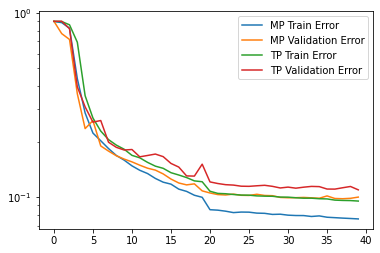

In [7]:
mp_optimizer = torch.optim.SGD(net_mp.parameters(), lr=.001, momentum=0.9, weight_decay=5e-4)
tp_optimizer = torch.optim.SGD(net_tp.parameters(), lr=.001, momentum=0.9, weight_decay=5e-4)

for epoch in range(20):
    train_correct,train_total,train_loss=run_epoch(net_mp, trainloader, criterion, 'cuda', mp_optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net_mp, testloader, criterion, 'cuda', None)
    test_err=1-float(test_correct)/test_total
    mp_train_performance.append(train_err)
    mp_validation_performance.append(test_err)
    mp_times.append(time.time())

    train_correct,train_total,train_loss=run_epoch(net_tp, trainloader, criterion, 'cuda', tp_optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net_tp, testloader, criterion, 'cuda', None)
    test_err=1-float(test_correct)/test_total
    
    tp_train_performance.append(train_err)
    tp_validation_performance.append(test_err)
    tp_times.append(time.time())

    print(("Epoch: {} Train Error: {:0.2f}% Validation Error: {:0.2f}% Loss: {}".format(
        epoch,100*train_err,100*test_err,train_loss)))
    plt.clf()
    plt.semilogy(range(len(mp_train_performance)),mp_train_performance)
    plt.semilogy(range(len(mp_validation_performance)), mp_validation_performance)
    plt.semilogy(range(len(tp_train_performance)), tp_train_performance)
    plt.semilogy(range(len(tp_validation_performance)), tp_validation_performance)
    plt.legend(["MP Train Error","MP Validation Error", "TP Train Error","TP Validation Error"])
    plt.draw()